# 004 · Visual Similarity (Gender-only) – Business-Friendly Notebook

**Goal 目标**
- Provide an easy-to-read evaluation of *visual similarity* for out-of-stock replacement.
- Only keep **gender filter** (no category filter). 不启用品类过滤，仅启用性别过滤。
- **No hit-rate style metrics**. We only report *average visual similarity* at K. 仅统计相似度相关指标（平均相似度）。
- Mark same-ID items in results; exclude the **exact same image** as the query. 标注同 `item_id`，同时排除与查询图片完全相同的那张图。

**Expected folder layout 目录结构（相对本 Notebook 所在目录）**
```
workflow/
  data/
    features.npy
    keys.csv
    img/  (contains images, e.g. WOMEN/Blouses_Shirts/...)
```


In [42]:
# %% [Setup] Imports & Paths / 导入与路径
from pathlib import Path
import os, re, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ✅ FIXED PATH: go one level up from current folder to reach workflow/data
WORKDIR = Path(r"D:\Icey\tcd\notebooks\dMining\Group Project\workflow")
DATA_DIR = WORKDIR / "data"
FEAT_PATH = DATA_DIR / "features.npy"
KEYS_PATH = DATA_DIR / "keys.csv"
IMG_ROOT  = DATA_DIR / "img"   # very important: images live under data/img

assert FEAT_PATH.exists(), f"features.npy not found: {FEAT_PATH}"
assert KEYS_PATH.exists(), f"keys.csv not found: {KEYS_PATH}"
assert IMG_ROOT.exists(), f"Image root not found: {IMG_ROOT}"

print("Working dir:", WORKDIR)
print("Data dir:   ", DATA_DIR)
print("Image root: ", IMG_ROOT)


Working dir: D:\Icey\tcd\notebooks\dMining\Group Project\workflow
Data dir:    D:\Icey\tcd\notebooks\dMining\Group Project\workflow\data
Image root:  D:\Icey\tcd\notebooks\dMining\Group Project\workflow\data\img


In [43]:
# %% [Load] Features & Keys / 读取数据
F = np.load(FEAT_PATH)
keys = pd.read_csv(KEYS_PATH)

print("Features shape:", F.shape)
print("Keys shape:", keys.shape)
keys.head(3)

Features shape: (26830, 2048)
Keys shape: (26830, 6)


,image_path,item_id,eval_split,in_stock,gender,category
0,WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts
1,WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,id_00000001,query,1,WOMEN,Blouses_Shirts
2,WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts


In [44]:
# %% [Sanity] Build absolute image paths & quick existence check / 构造绝对路径并抽查
def to_abs(p):
    if pd.isna(p):
        return None
    return (IMG_ROOT / str(p).replace("\\", "/")).resolve()

keys["abs_img_path"] = keys["image_path"].apply(to_abs)

# quick check for the first few
for i in range(min(3, len(keys))):
    ap = keys.loc[i, "abs_img_path"]
    print(i, os.path.exists(ap), ap)


0 True D:\Icey\tcd\notebooks\dMining\Group Project\workflow\data\img\WOMEN\Blouses_Shirts\id_00000001\02_1_front.jpg
1 True D:\Icey\tcd\notebooks\dMining\Group Project\workflow\data\img\WOMEN\Blouses_Shirts\id_00000001\02_2_side.jpg
2 True D:\Icey\tcd\notebooks\dMining\Group Project\workflow\data\img\WOMEN\Blouses_Shirts\id_00000001\02_3_back.jpg


In [45]:
# %% [Prep] Normalize gender from path / 从路径中解析性别
def parse_gender_from_path(p):
    s = str(p).replace("\\", "/").upper()
    if s.startswith("WOMEN/"):
        return "WOMEN"
    if s.startswith("MEN/"):
        return "MEN"
    # fallback: try from existing column if any
    return "WOMEN" if "WOMEN" in s else ("MEN" if "MEN" in s else "")

if "gender" in keys.columns:
    keys["gender"] = keys["gender"].fillna("").astype(str).str.upper().str.strip()
keys["gender_norm"] = keys["image_path"].apply(parse_gender_from_path)

print(keys[["image_path","gender","gender_norm"]].head(3))


                                        image_path gender gender_norm
0  WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg  WOMEN       WOMEN
1   WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg  WOMEN       WOMEN
2   WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg  WOMEN       WOMEN


In [46]:
# %% [Index] Build KNN (cosine) / 建立余弦距离KNN索引
knn = NearestNeighbors(n_neighbors=200, metric="cosine")
knn.fit(F)
print("KNN ready.")


KNN ready.


In [47]:
# %% [Helpers] Retrieval & metrics / 检索与指标
def run_knn_for_query(q_idx:int, topn:int=200, gender_filter:bool=True):
    """Return a DataFrame of candidates for a query index.
    - Exclude the **exact same image** as the query.
    - If gender_filter=True, keep same gender only.
    - Compute similarity = 1 - distance.
    """
    q_vec = F[q_idx].reshape(1, -1)
    dist, idx = knn.kneighbors(q_vec, n_neighbors=topn)
    dist = dist[0]; idx = idx[0]

    q = keys.iloc[q_idx]
    q_gender = q.get("gender_norm", "")
    q_img    = str(q.get("image_path", ""))
    q_item   = str(q.get("item_id", ""))

    cand = keys.iloc[idx].copy()
    cand["distance"] = dist
    cand["similarity"] = 1.0 - dist

    # exclude the exact same image
    cand = cand[cand["image_path"].astype(str) != q_img]

    # gender filter
    if gender_filter and q_gender:
        cand = cand[cand["gender_norm"] == q_gender]

    # add same_id flag
    cand["same_id"] = cand["item_id"].astype(str).eq(q_item)
    return q, cand.reset_index(drop=True)

def avg_similarity_at_k(cands_df, K: int=10):
    """Average visual similarity over top-K. 计算前K个的平均相似度"""
    return float(cands_df.head(K)["similarity"].mean()) if len(cands_df)>0 else 0.0


In [48]:
# %% [Evaluate · FAST] Average similarity at K (vectorized) / 向量化快速评估
# Config
KLIST = [1, 5, 10]
GENDER_FILTER = True     # 只保留同性别
TOPN_EVAL = 200          # 每个 query 取前多少候选参与计算（越大越准，越慢）

# 1) 选取要评估的 query 索引（优先 eval_split == 'query'）
if "eval_split" in keys.columns:
    q_idx_list = keys.index[keys["eval_split"].astype(str).str.lower().eq("query")].tolist()
    if len(q_idx_list) == 0:
        q_idx_list = list(range(min(200, len(keys))))
else:
    q_idx_list = list(range(min(200, len(keys))))

q_idx_arr = np.array(q_idx_list, dtype=int)

# 2) 批量 KNN：对所有 query 一次 kneighbors（比循环快很多）
#    knn 已在前面用 F.fit() 过，这里直接用；取较大的 TOPN_EVAL 以便过滤后仍有足够候选
dist_all, idx_all = knn.kneighbors(F[q_idx_arr], n_neighbors=TOPN_EVAL)
sim_all = 1.0 - dist_all  # 相似度

# 3) 向量化构造过滤 mask
#   3.1 排除“与查询完全相同的图片”（同索引）
same_image_mask = (idx_all == q_idx_arr[:, None])

#   3.2 性别过滤（同 gender）
q_gender_arr = keys.loc[q_idx_arr, "gender_norm"].astype(str).str.upper().str.strip().values
g_gender_all = keys["gender_norm"].astype(str).str.upper().str.strip().values
gender_ok_mask = (g_gender_all[idx_all] == q_gender_arr[:, None]) if GENDER_FILTER else np.ones_like(idx_all, dtype=bool)

#   3.3 最终可用 mask
keep_mask = (~same_image_mask) & gender_ok_mask

# 4) 计算 AvgSimilarity@K（逐行但纯 NumPy，避免 DataFrame 循环）
def avg_sim_at_k_from_masks(sim_row, keep_row, K):
    """
    给定一行 sim_row（长度 = TOPN_EVAL）和布尔 keep_row，
    取前 K 个 True 的相似度做平均；若不足 K，就对可用的做平均；若一个也没有，返回 0.
    """
    where = np.flatnonzero(keep_row)
    if where.size == 0:
        return 0.0
    sel = where[:K]  # 只取前 K 个满足条件的
    return float(sim_row[sel].mean())

rows = []
for K in KLIST:
    vals = np.fromiter(
        (avg_sim_at_k_from_masks(sim_all[i], keep_mask[i], K) for i in range(len(q_idx_arr))),
        dtype=float,
        count=len(q_idx_arr)
    )
    rows.append([K, float(vals.mean())])

metric_df = pd.DataFrame(rows, columns=["K", "AvgSimilarity@K"])
metric_df


,K,AvgSimilarity@K
0,1,0.845491
1,5,0.822359
2,10,0.809930


In [49]:
# %% [Viz] Show query vs Top-K / 可视化若干查询与Top-K
def show_topk(qi:int, K:int=5):
    q_row, cands = run_knn_for_query(qi, topn=200, gender_filter=True)
    top = cands.head(K)

    fig, axes = plt.subplots(1, K+1, figsize=(3*(K+1), 3.5))
    # query image
    q_path = (IMG_ROOT / str(q_row["image_path"]).replace("\\","/")).resolve()
    try:
        axes[0].imshow(Image.open(q_path).convert("RGB"))
    except Exception:
        axes[0].text(0.5,0.5,"(image missing)",ha="center")
    axes[0].set_title(f"QUERY\n{q_row.get('item_id','')}\n{q_row.get('gender_norm','')}")
    axes[0].axis("off")

    for j, (_, r) in enumerate(top.iterrows(), start=1):
        p = (IMG_ROOT / str(r["image_path"]).replace("\\","/")).resolve()
        try:
            axes[j].imshow(Image.open(p).convert("RGB"))
        except Exception:
            axes[j].text(0.5,0.5,"(image missing)",ha="center")
        sid = " (same ID)" if str(r.get("item_id","")) == str(q_row.get("item_id","")) else ""
        axes[j].set_title(f"#{j} s={r['similarity']:.3f}{sid}\n{r.get('gender_norm','')}")
        axes[j].axis("off")
    plt.tight_layout(); plt.show()

# Example 示例（可多试几次不同下标）
# show_topk(0, K=5)


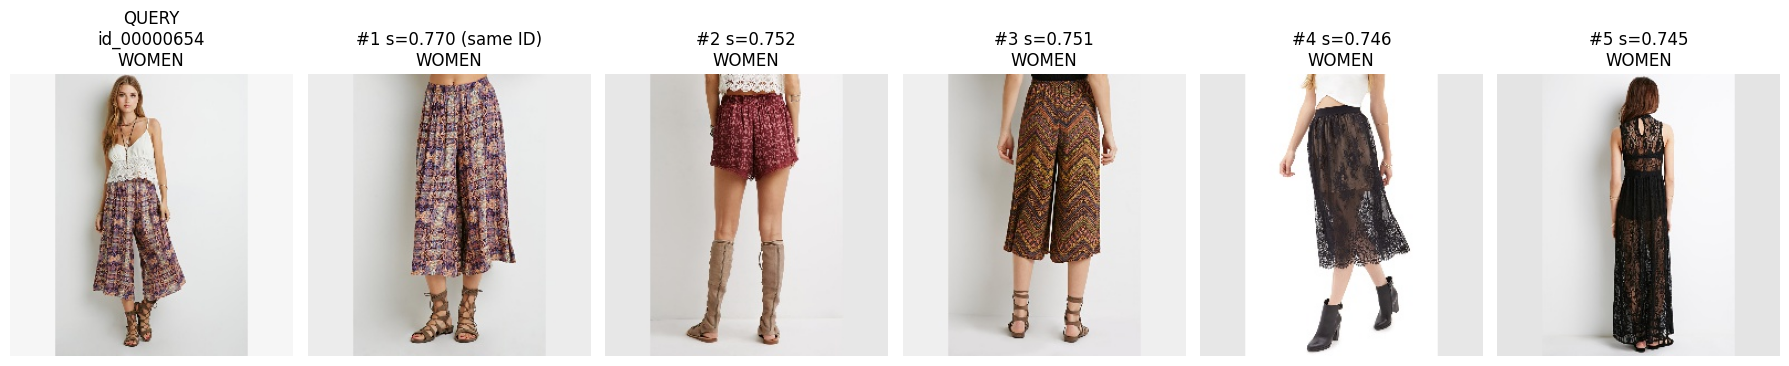

In [55]:
# Example 示例（可多试几次不同下标）
show_topk(2005, K=5)